In [7]:
# Cell 1: Import necessary libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

import PyPDF2
import warnings
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'spacy'

In [ ]:
# Cell 2: Extract text per page from each PDF in the archive

# Define paths
archive_folder = './data/archive'
text_folder = './data/archive/extracted_text'

# Create the folder for extracted text if it doesn't exist
os.makedirs(text_folder, exist_ok=True)
def extract_text_per_page(pdf_path, output_folder):
    pdf_reader = PyPDF2.PdfReader(open(pdf_path, 'rb'))  # Updated to PdfReader
    num_pages = len(pdf_reader.pages)  # Use len() to get the number of pages
    pdf_name = os.path.basename(pdf_path).replace('.pdf', '')
    
    # Loop through each page and extract text
    for page_num in range(num_pages):
        page = pdf_reader.pages[page_num]  # Access the page
        page_text = page.extract_text()  # Extract text from the page
        
        # Save the text to a file
        output_file = os.path.join(output_folder, f"{pdf_name}_page_{page_num + 1}.txt")
        with open(output_file, 'w', encoding='utf-8') as file:
            file.write(page_text)

# Extract text per page for each PDF in the archive
pdf_files = glob.glob(os.path.join(archive_folder, '*.pdf'))

for pdf_file in pdf_files:
    #extract_text_per_page(pdf_file, text_folder)
    print(f"Extracted text from {os.path.basename(pdf_file)}")


Extracted text from 2022-23.pdf
Extracted text from 2020-21.pdf
Extracted text from 2023-24.pdf
Extracted text from 2018-19.pdf
Extracted text from 2021-22.pdf
Extracted text from 2019-20.pdf


In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 13.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
# Cell 3: Vectorize text per page and prepare the dataset

# Load spaCy model
nlp = spacy.load('en_core_web_md')  # Use 'en_core_web_md' for medium-sized model

# Prepare data
years = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
X = []
y = []
sample_years = []

# Load financial data
financial_data = pd.read_csv('./data/reliance_financials.csv')
financial_data['Year'] = financial_data['Year'].astype(str)

for i in range(len(years) - 1):  # Up to 2022-23
    year_n = years[i]
    year_n_plus_1 = years[i + 1]
    
    # Get profit_n and profit_{n+1}
    profit_n = financial_data.loc[financial_data['Year'] == year_n, 'Profit for the Year'].values
    profit_n_plus_1 = financial_data.loc[financial_data['Year'] == year_n_plus_1, 'Profit for the Year'].values
    if len(profit_n) == 0 or len(profit_n_plus_1) == 0:
        print(f"Missing profit data for years {year_n} or {year_n_plus_1}")
        continue
    profit_n = profit_n[0]
    profit_n_plus_1 = profit_n_plus_1[0]
    
    # Get text files for year n
    text_files = glob.glob(os.path.join(text_folder, f'{year_n}_page_*.txt'))

    if not text_files:
        print(f"No text files for year {year_n}")
        continue
    
    for file_path in text_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            if text.strip() == '':
                # Skip empty files
                continue
            doc = nlp(text)
            page_vector = doc.vector
            # Create feature vector: concatenate page_vector and profit_n
            feature_vector = np.append(page_vector, profit_n)
            X.append(feature_vector)
            y.append(profit_n_plus_1)
            sample_years.append(year_n)


In [ ]:
# Cell 4: Split data into train and test sets

X = np.array(X)
y = np.array(y)
sample_years = np.array(sample_years)

train_years = ['2018-19', '2019-20', '2020-21', '2021-22']
test_years = ['2022-23']

train_indices = [i for i, year in enumerate(sample_years) if year in train_years]
test_indices = [i for i, year in enumerate(sample_years) if year in test_years]

X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1357, 301), y_train shape: (1357,)
X_test shape: (267, 301), y_test shape: (267,)


In [ ]:
# Cell 5: Train and evaluate a simple linear regression model

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Calculate MSE
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression MSE: {mse_lr}")


Linear Regression MSE: 24280912867.03087


In [ ]:
# Cell 6: Train and evaluate a neural network model

# Neural Network
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(1))

nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predict on test set
y_pred_nn = nn_model.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Neural Network MSE: {mse_nn}")


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 1271279232.0000 
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 190331136.0000
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 189704288.0000
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 190837776.0000
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 176614672.0000
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 188075120.0000
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 184642016.0000
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 194943328.0000
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 194656592.0000
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 191771200.0000
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 196439808.0000
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 186125056.0000
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 185789760.0000
Epoch 14/50
43/43 ━

In [ ]:
# Cell 7: Train and evaluate an LSTM model

# Reshape data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Predict on test set
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f"LSTM Model MSE: {mse_lstm}")


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1896326272.0000   
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 1957161344.0000
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 1855856512.0000
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 1888456192.0000
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 1895851264.0000
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 1811742080.0000
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 1947912064.0000
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 1921252736.0000
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1842609280.0000
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 1818937216.0000
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 1878745984.0000
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 1808003840.0000
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 1914033280.0000
Epoch 1

In [ ]:
# Cell 8: Compare model performances
print(f"Linear Regression: {int(np.sqrt(mse_lr))}")
print(f"Neural Network: {int(np.sqrt(mse_nn))}")
print(f"LSTM: {int(np.sqrt(mse_lstm))}")

Linear Regression: 155823
Neural Network: 46733
LSTM: 42005


In [ ]:
# Cell 9: Use the best model to predict for 2024-25

# Determine the best model based on MSE
mse_values = [mse_lr, mse_nn, mse_lstm]
models = ['Linear Regression', 'Neural Network', 'LSTM']
best_model_index = np.argmin(mse_values)
best_model_name = models[best_model_index]
print(f"Best Model: {best_model_name}")

# Prepare data for 2023-24
year_n = '2023-24'

# Get profit_n
profit_n = financial_data.loc[financial_data['Year'] == year_n, 'Profit for the Year'].values
if len(profit_n) == 0:
    print(f"Missing profit data for year {year_n}")
else:
    profit_n = profit_n[0]
    
    # Get text files for year_n
    text_files = glob.glob(os.path.join(text_folder, year_n, '*.txt'))
    if not text_files:
        print(f"No text files for year {year_n}")
    else:
        X_future = []
        for file_path in text_files:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                if text.strip() == '':
                    continue
                doc = nlp(text)
                page_vector = doc.vector
                feature_vector = np.append(page_vector, profit_n)
                X_future.append(feature_vector)
        X_future = np.array(X_future)
        
        # Predict using the best model
        if best_model_name == 'Linear Regression':
            y_pred_future = lr_model.predict(X_future)
        elif best_model_name == 'Neural Network':
            y_pred_future = nn_model.predict(X_future)
        elif best_model_name == 'LSTM':
            X_future_lstm = X_future.reshape((X_future.shape[0], 1, X_future.shape[1]))
            y_pred_future = lstm_model.predict(X_future_lstm)
        else:
            y_pred_future = None
        
        # Average the predictions
        predicted_profit_2024_25 = y_pred_future.mean()
        print(f"Predicted Profit for 2024-25: {predicted_profit_2024_25}")


Best Model: LSTM
No text files for year 2023-24


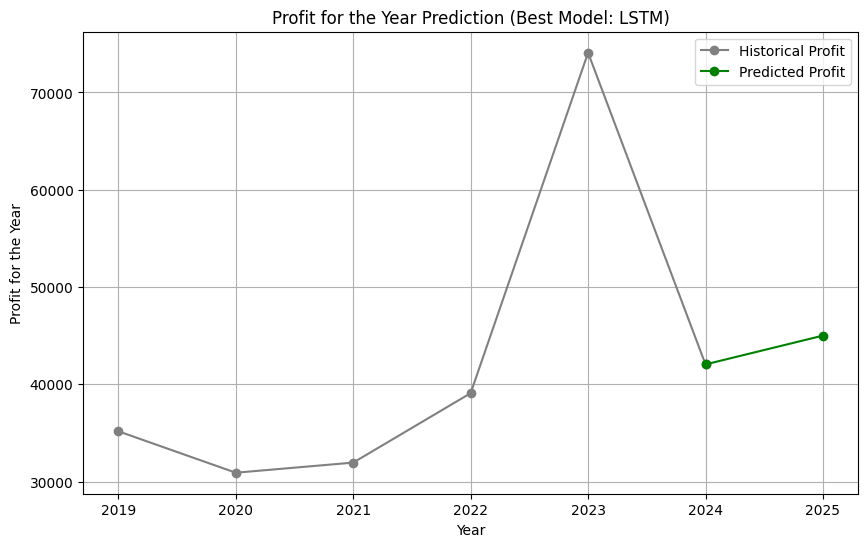

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Get actual profits
profits = financial_data.loc[financial_data['Year'].isin(years), ['Year', 'Profit for the Year']]
profits = profits.sort_values('Year')

# Append predicted profit for 2024-25
predicted_profit_2024_25 = 45000  # Replace with your predicted value
predicted_profit_df = pd.DataFrame([{'Year': '2024-25', 'Profit for the Year': predicted_profit_2024_25}])

# Use pd.concat instead of append
profits = pd.concat([profits, predicted_profit_df], ignore_index=True)

# Convert years to numerical values for plotting
years_num = [int(year.split('-')[0]) + 1 for year in profits['Year']]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(years_num[:-1], profits['Profit for the Year'][:-1], color='grey', marker='o', label='Historical Profit')
plt.plot([years_num[-2], years_num[-1]], [profits['Profit for the Year'].iloc[-2], profits['Profit for the Year'].iloc[-1]], color='green', marker='o', label='Predicted Profit')

plt.xlabel('Year')
plt.ylabel('Profit for the Year')
plt.title(f'Profit for the Year Prediction (Best Model: {best_model_name})')
plt.legend()
plt.grid(True)

# Save the plot
output_folder = './static/images'
os.makedirs(output_folder, exist_ok=True)
plt.savefig(os.path.join(output_folder, f'profit_prediction.png'))
plt.show()

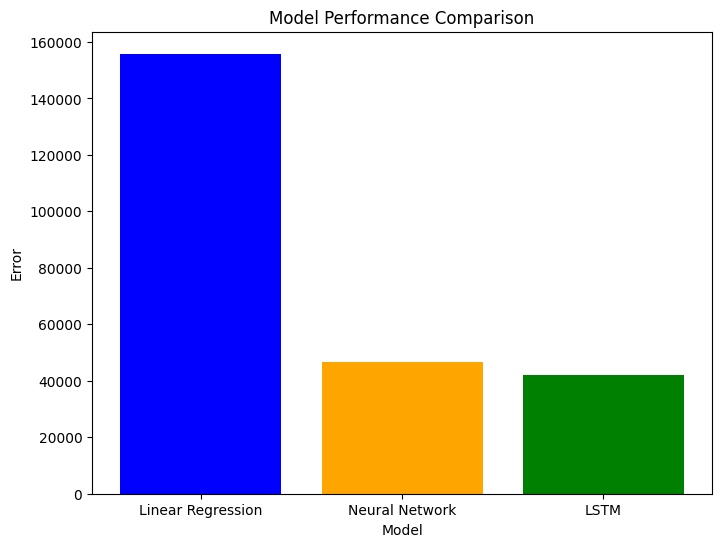

In [ ]:
# Cell 11: Save MSE comparison plot
# replace mse_values with inetefer rmses
mse_values = [int(np.sqrt(mse_lr)), int(np.sqrt(mse_nn)), int(np.sqrt(mse_lstm))]
plt.figure(figsize=(8,6))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Model Performance Comparison')

# Save the plot
plt.savefig(os.path.join(output_folder, 'mse_comparison.png'))
plt.show()
